In [32]:
import os
import numpy as np
import pandas as pd
import spacy
from transformers import BertTokenizer
from parse_scripts_noindent import parse_lines
from tqdm import tqdm
from matplotlib import pyplot as plt
import math

In [3]:
line_indices_file = "/workspace/mica-text-robust-script-parser/data/SAIL_annotation_screenplays/line_indices.txt"

movies, starts, ends = [], [], []

for line in open(line_indices_file).read().splitlines():
    movie, _, start, end = line.split()
    movies.append(movie)
    starts.append(int(start))
    ends.append(int(end))

In [32]:
annotator_1_df_dict = pd.read_excel("/workspace/mica-text-robust-script-parser/data/Annotator_1.xlsx", sheet_name=None, header=1, usecols=["line","S","N","C","D","E","T","M"])

annotator_2_df_dict = pd.read_excel("/workspace/mica-text-robust-script-parser/data/Annotator_2.xlsx", sheet_name=None, header=1, usecols=["line","S","N","C","D","E","T","M"])

annotator_3_df_dict = pd.read_excel("/workspace/mica-text-robust-script-parser/data/Annotator_3.xlsx", sheet_name=None, header=1, usecols=["line","S","N","C","D","E","T","M"])

In [34]:
data = {}

for movie, start, end in zip(movies, starts, ends):
    screenplay_file = os.path.join("/workspace/mica-text-robust-script-parser/data/SAIL_annotation_screenplays/screenplays", movie + ".txt")
    script = open(screenplay_file).read().splitlines()

    begin_script = [line.strip() for line in script[:start] if len(line.strip()) > 0]
    middle_script = [line.strip() for line in script[start:end] if len(line.strip()) > 0]
    end_script = [line.strip() for line in script[end:] if len(line.strip()) > 0]

    start = len(begin_script)
    end = start + len(middle_script)
    script = begin_script + middle_script + end_script

    data[movie] = {
        "movie": movie,
        "script": script,
        "start": start,
        "end": end
    }

    all_anns = []

    ann_lines = []

    for i, df in enumerate([annotator_1_df_dict[movie], annotator_2_df_dict[movie], annotator_3_df_dict[movie]]):
        anns = []

        for _, row in df.iterrows():
            if pd.notna(row["line"]) and str(row["line"]).strip() != "":
                ann_lines.append(str(row["line"]).strip())
                n = 0
                atag = ""
                for tag in ["S","N","C","D","E","T","M"]:
                    if str(row["line"]).strip() == str(row[tag]).strip():
                        atag = tag
                    else:
                        n += 1
                if atag != "" and n == 6:
                    anns.append(atag)
                else:
                    anns.append("O")
        
        all_anns.append(anns)
    
    maj = []
    for a1, a2, a3 in zip(all_anns[0], all_anns[1], all_anns[2]):
        if a1 == a2 or a1 == a3:
            maj.append(a1)
        elif a2 == a3:
            maj.append(a2)
        else:
            maj.append("O")
    data[movie]["label"] = maj

    # print(len(middle_script), len(maj), len(middle_script) == len(maj), movie)

    if data[movie]["end"] - data[movie]["start"] != len(data[movie]["label"]):
        print(movie, start, end)
        n = min(end - start, len(maj))

        for script_line, ann_line in zip(middle_script[:n], ann_lines[:n]):
            print("[{}] [{}]".format(script_line, ann_line))

In [37]:
for movie in data:
    tags = parse_lines(data[movie]["script"])
    data[movie]["parse"] = tags[data[movie]["start"]: data[movie]["end"]]

In [41]:
for tag in ["S","N","C","D","E","T"]:
    tp, fp, fn = 0, 0, 0
    for movie in data:
        tp += sum(x == y == tag for x, y in zip(data[movie]["label"], data[movie]["parse"]))
        fp += sum(x != y == tag for x, y in zip(data[movie]["label"], data[movie]["parse"]))
        fn += sum(tag == x != y for x, y in zip(data[movie]["label"], data[movie]["parse"]))
    p = tp/(tp + fp)
    r = tp/(tp + fn)
    f1 = 2*p*r/(p + r)
    print("\t{}: p = {:5.1f}, r = {:5.1f}, f1 = {:5.1f}".format(tag, 100*p, 100*r, 100*f1))

	S: p = 100.0, r =   0.3, f1 =   0.6
	N: p =  85.7, r =   0.2, f1 =   0.4
	C: p =  87.3, r =  99.3, f1 =  92.9
	D: p =  50.5, r =  96.3, f1 =  66.3
	E: p =  70.8, r =  94.8, f1 =  81.1
	T: p = 100.0, r =   1.5, f1 =   2.9


In [64]:
nlp = spacy.load("en_core_web_lg", disable=["parser","ner"])

In [45]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [47]:
print(tokenizer.name_or_path)
print(nlp.path)

bert-base-cased
/opt/conda/envs/parser/lib/python3.8/site-packages/en_core_web_lg/en_core_web_lg-3.2.0


In [67]:
n_words_per_line = []
tmovie = tqdm(movies)

for movie in tmovie:
    tmovie.set_description("{:30s}".format(movie))
    mdata = data[movie]
    script = mdata["script"][mdata["start"]: mdata["end"]]
    
    for line in script:
        doc = nlp(line)
        n_tokens = len(doc)
        n_words_per_line.append(n_tokens)    

xmen                          : 100%|██████████| 39/39 [00:12<00:00,  3.22it/s] 


In [68]:
len(n_words_per_line)

9758

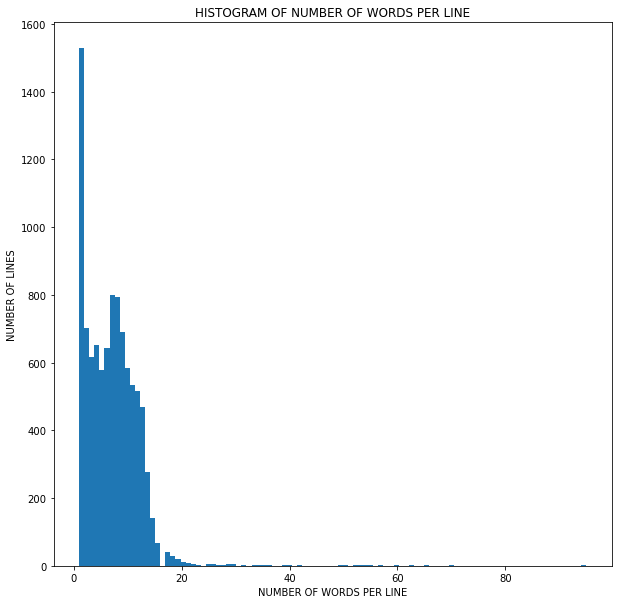

In [69]:
plt.figure(figsize=(10,10))
plt.hist(n_words_per_line, bins=100)
plt.xlabel("NUMBER OF WORDS PER LINE")
plt.ylabel("NUMBER OF LINES")
plt.title("HISTOGRAM OF NUMBER OF WORDS PER LINE")
plt.show()

In [70]:
sum(x <= 20 for x in n_words_per_line)/len(n_words_per_line)

0.9933387989342078

In [76]:
tok2vec = nlp.components[0][1]

In [7]:
def func(a):
    # a = a[:]
    a = list(reversed(a))
    return a

def gunc(a):
    a = a[:]
    a[0] = "@"
    return a

a = ["1", "2", "3", "4", "5"]
print(gunc(a))
print(func(a))
print(a)

['@', '2', '3', '4', '5']
['5', '4', '3', '2', '1']
['1', '2', '3', '4', '5']


In [29]:
df = pd.read_csv("/workspace/mica-text-robust-script-parser/results/data.csv", index_col=None)
print(df.columns)

Index(['movie', 'line_no', 'text', 'label', 'error'], dtype='object')


In [30]:
df1 = df[(df.movie == "44_inch_chest") & (df.error == "NONE")]
df2 = df[(df.movie == "44_inch_chest") & (df.error == "ASTERISKS_NUMBERS")]
print(df1.shape, df2.shape)

(251, 5) (251, 5)


In [31]:
lines1 = df1.text.values
lines2 = df2.text.values

for line1, line2 in zip(lines1, lines2):
    print(line1)
    print(line2)
    print()

out to wear ... whatever combination - it
67     out to wear ... whatever combination - it     73

works! - You look superb! ... And your
66     works! - You look superb! ... And your     9

underw ear - immac ulate ! 100 % cot ton!
underw ear - immac ulate ! 100 % cot ton!

Dazzlin'!... Not like my pinky grey-y
Dazzlin'!... Not like my pinky grey-y

things! Nah, you've just got it - good at
76     things! Nah, you've just got it - good at     61

everythin'! ... Me - on the other hand -
everythin'! ... Me - on the other hand -

I'm good at sittin'!... Sit, sit, sit...
I'm good at sittin'!... Sit, sit, sit...

watch, watch, watch ... drink, drink,
watch, watch, watch ... drink, drink,

drink... Honestly, she must've spent                        *
2     drink... Honestly, she must've spent                        *     0

half our marriage yawnin "... The kids --
half our marriage yawnin "... The kids --

d'you know what they call me? - Captain
42     d'you know what they call me? - Capt

In [33]:
math.ceil(0.2)

1

In [48]:
n = 3

n_test = math.ceil(0.1 * n)
n_train = n - 2 * n_test
arr = n_test * ["test"] + n_test * ["dev"] + n_train * ["train"]
np.random.shuffle(arr)
print(arr)

['test', 'dev', 'train']
